In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.manifold import Grassmann
import torch.autograd as autograd
from src.s_svgd import SlicedSVGD
from src.diffusion import Diffusion
import pickle
import argparse
import time
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as npr_dist
import jax.random as random
import jax.numpy as jnp
import jax
from src.Tmy_svgd import tmySVGD

/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser(description="Running xshaped experiment.")
parser.add_argument("--dim", type=int, default=25, help="dimension")
parser.add_argument("--effdim", type=int, default=5, help="dimension")
parser.add_argument("--lr", type=float, default=0.01, help="learning rate")
parser.add_argument("--lr_g", type=float, default=0.1, help="learning rate for S-SVGD")
parser.add_argument(
    "--delta", type=float, default=0.1, help="stepsize for projections"
)
parser.add_argument(
    "--T", type=float, default=1e-4, help="noise multiplier for projections"
)
parser.add_argument("--nparticles", type=int, default=100, help="no. of particles")
parser.add_argument("--epochs", type=int, default=1000, help="no. of epochs")
parser.add_argument("--noise", type=str, default="True", help="whether to add noise")
parser.add_argument("--kernel", type=str, default="rbf", help="kernel")
parser.add_argument("--gpu", type=int, default=0, help="gpu")
parser.add_argument("--seed", type=int, default=0, help="random seed")
parser.add_argument("--suffix", type=str, default="", help="suffix for res folder")
parser.add_argument("--method", type=str, default="svgd", help="svgd, gsvgd or s-svgd")
parser.add_argument("--save_every", type=int, default=100, help="batch size")

args = parser.parse_args([])

In [3]:
dim = args.dim
lr = args.lr
lr_g = args.lr_g
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = 10
add_noise = True if args.noise == "True" else False
save_every = args.save_every  # save metric values every 100 epochs
print(f"Running for lr: {lr}, nparticles: {nparticles}")

device = torch.device(f"cuda:{args.gpu}" if args.gpu != -1 else "cpu")


Running for lr: 0.01, nparticles: 100


In [4]:
results_folder = f"./res/diffusion{args.suffix}/{args.kernel}_epoch{epochs}_lr{lr}_delta{delta}_n{nparticles}_dim{dim}"
results_folder = f"{results_folder}/seed{seed}"

In [5]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if args.kernel == "rbf":
    Kernel = RBF
    BatchKernel = BatchRBF

In [6]:
print(f"Device: {device}")
torch.manual_seed(seed)
np.random.seed(seed)

## initialize conditional diffusion
beta = 10
sigma = 0.1

distribution = Diffusion(dim, beta, device=device)

loc = torch.arange(0, dim+1, 5)[1:]
distribution.loc = loc
noise_covariance = torch.diag(sigma**2 * torch.ones(len(loc), device=device))
distribution.set_noise_covariance(noise_covariance)
distribution.set_C()

x_true = distribution.brownian_motion((1, dim))
u_true = distribution.solution(x_true)

obs_noise = torch.normal(0, sigma, size=(1, len(loc))).to(device)
obs = u_true[:, loc] + obs_noise
distribution.obs = obs

# initialize particles
x0 = distribution.brownian_motion((nparticles, dim))

C = distribution.C.cpu().numpy()
dt = distribution.dt.cpu().numpy()
loc = distribution.loc.cpu().numpy()
beta = distribution.beta




Device: cuda:0


In [7]:
## SVGD
print("Running SVGD")
x = x0.clone().requires_grad_()
# sample from variational density
kernel = Kernel(method="med_heuristic")
svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)

start = time.time()
svgd.fit(x, epochs=epochs, save_every=save_every)
elapsed_time = time.time() - start

fitted_method = svgd
#particles = fitted_method.particles
particles = x

method_name = "svgd"



## save results
pickle.dump(
     {
            **{"x_true": x_true},
            **{"u_true": u_true},
            **{"particles": particles},
            **{"time": elapsed_time}
    },
    open(results_folder + f"/particles_svgd.p", "wb")
)

# target distribution
torch.save(distribution, results_folder + '/target_dist.p')

Running SVGD


100%|██████████| 1000/1000 [00:35<00:00, 28.35it/s]


In [8]:
print("Running min_mySVGD")


def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        #print(score_func)
        return score_func


# sample from variational density

lr = 0.01
x = x0.clone().requires_grad_()
vector1  = torch.randn(nparticles, dim).to(device)
model  = tmySVGD(kernel, device)
start = time.time()
    
theta, vector = model.update(x, score,  k = 2, n_iter =2000,  debug = False, lr= lr, vector=vector1)
elapsed_time = time.time() - start
particles = theta

## save results
pickle.dump(
        {
            **{"x_true": x_true},
            **{"u_true": u_true},
            **{"particles": particles},
            **{"time": elapsed_time}
        },
open(results_folder + f"/particles_AUmp_svgd.p", "wb")
)


print(particles)


Running min_mySVGD


100%|██████████| 2000/2000 [06:11<00:00,  5.38it/s]

tensor([[-0.1854, -0.4132, -0.6081,  ...,  0.4247,  0.2916,  0.0470],
        [-0.4113, -0.5241, -0.5275,  ...,  1.4453,  0.9268,  0.5104],
        [-0.2030, -0.1023, -0.1510,  ...,  0.0719,  0.0631, -0.2642],
        ...,
        [-0.5141, -0.7479, -0.5631,  ..., -0.0705, -0.5233, -0.7227],
        [ 0.0249, -0.4134, -0.5620,  ...,  0.9600,  0.8465,  0.4886],
        [-0.1850, -0.2419, -0.1832,  ...,  0.7059,  0.6683,  0.3884]],
       device='cuda:0', grad_fn=<CopySlices>)


In [9]:
eff_dim = args.effdim
print(f"Running GSVGD with eff dim = {eff_dim}")

m = min(20, dim // eff_dim)
print("number of projections:", m)

# sample from variational density
x_gsvgd = x0.clone().requires_grad_()

kernel_gsvgd = BatchKernel(method="med_heuristic")
optimizer = optim.Adam([x_gsvgd], lr=lr)
manifold = Grassmann(dim, eff_dim)
U = torch.eye(dim).requires_grad_(True).to(device)
U = U[:, :(m*eff_dim)]

gsvgd = FullGSVGDBatch(
    target=distribution,
    kernel=kernel_gsvgd,
    manifold=manifold,
    optimizer=optimizer,
    delta=delta,
    T=T,
    device=device,
    noise=add_noise
)

start = time.time()
U, metric_gsvgd = gsvgd.fit(x_gsvgd, U, m, epochs, 
    verbose=True, save_every=save_every, threshold=1e-2)
elapsed_time = time.time() - start

particles = x_gsvgd

pickle.dump(
{
            **{"x_true": x_true},
            **{"u_true": u_true},
            **{"particles": particles},
            **{"time": elapsed_time}
        },
open(results_folder + f"/particles_gsvgd.p", "wb")
)




Running GSVGD with eff dim = 5
number of projections: 5


100%|█████████▉| 999/1000 [01:45<00:00,  9.51it/s]/home/zhoujk/SVGD/SVGD_code/GSVGD-main/src/gsvgd.py:262: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  A, _ = torch.qr(A)
100%|██████████| 1000/1000 [01:45<00:00,  9.47it/s]


In [10]:
## S-SVGD
# sample from variational density
print("Running S-SVGD")
x_s_svgd = x0.clone().requires_grad_()
s_svgd = SlicedSVGD(distribution, device=device)

start = time.time()
x_s_svgd, metric_s_svgd = s_svgd.fit(
    samples=x_s_svgd, 
    n_epoch=epochs, 
    lr=lr_g,
    eps=lr,
    save_every=save_every
)
elapsed_time = time.time() - start

fitted_method = s_svgd
particles = x_s_svgd

pickle.dump(
{
            **{"x_true": x_true},
            **{"u_true": u_true},
            **{"particles": particles},
            **{"time": elapsed_time}
        },
open(results_folder + f"/particles_ssvgd.p", "wb")
)


Running S-SVGD


100%|██████████| 1000/1000 [01:08<00:00, 14.62it/s]


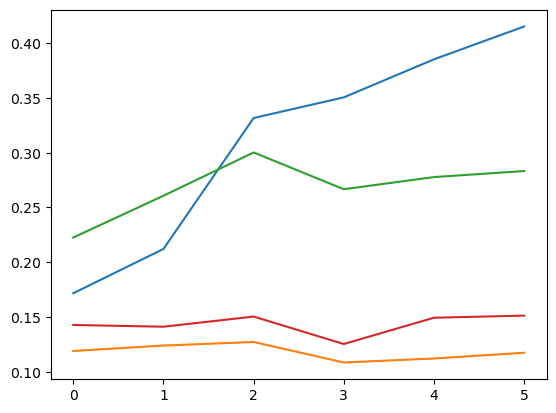

In [11]:
a = torch.load("/home/zhoujk/energy_xshape_mu_vs_35.pt")
import os
import matplotlib.pyplot as plt 


plt.plot(a[:6,0])
plt.plot(a[:6,1])
plt.plot(a[:6,2])
plt.plot(a[:6,3])


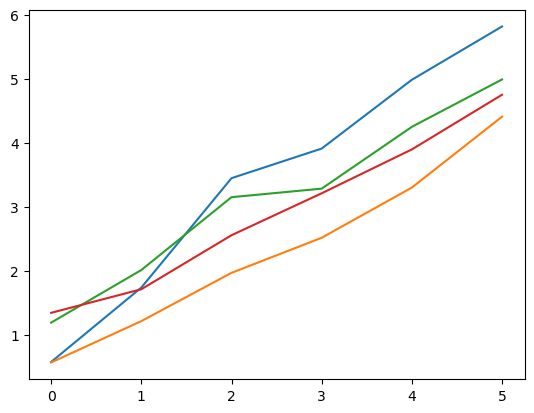

In [12]:
a = torch.load("/home/zhoujk/norm_xshape_mu_vs_35.pt")
a = a.detach().numpy() 
plt.plot(a[:6,0])
plt.plot(a[:6,1])
plt.plot(a[:6,2])
plt.plot(a[:6,3])


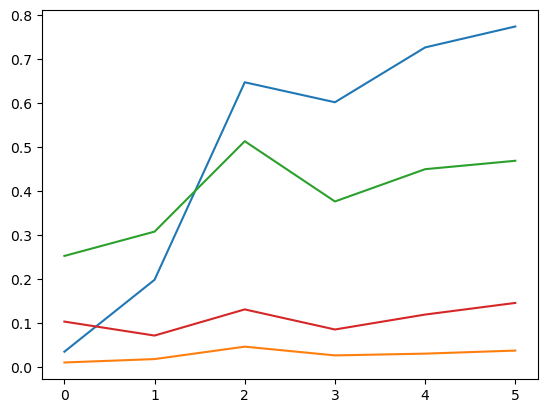

In [13]:
a = torch.load("/home/zhoujk/gr_xshape_mu_vs_35.pt")
a = a.detach().numpy() 
plt.plot(a[:6,0])
plt.plot(a[:6,1])
plt.plot(a[:6,2])
plt.plot(a[:6,3])


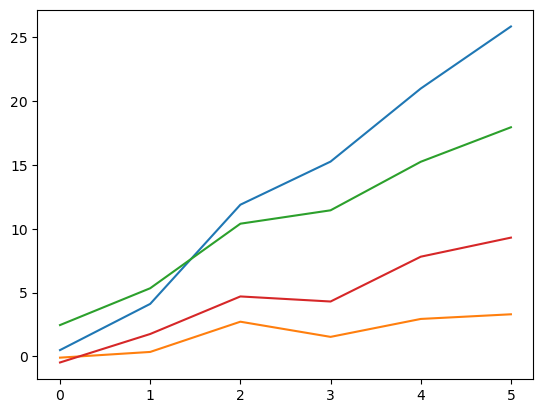

In [14]:
a = torch.load("/home/zhoujk/tr_xshape_mu_vs_35.pt")
a = a.detach().numpy() 
plt.plot(a[:6,0])
plt.plot(a[:6,1])
plt.plot(a[:6,2])
plt.plot(a[:6,3])


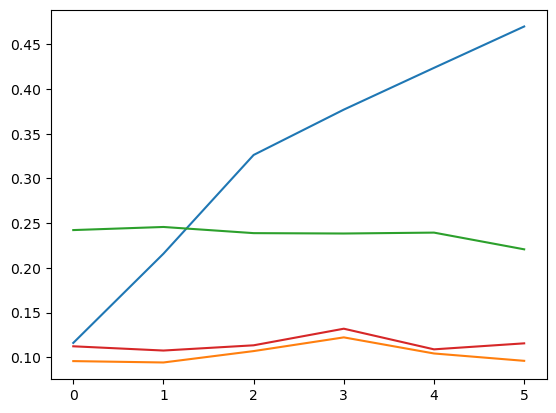

In [15]:
a = torch.load("/home/zhoujk/energy_gauss_mu_vs_35.pt")
a = a.detach().numpy() 
plt.plot(a[:6,0])
plt.plot(a[:6,1])
plt.plot(a[:6,2])
plt.plot(a[:6,3])

array([[0.62791395, 0.33752096, 1.4852755 , 0.39458203],
       [1.7730438 , 0.74952036, 2.066678  , 1.0671511 ],
       [2.9412723 , 1.0631123 , 2.4207335 , 1.8358674 ],
       [3.652737  , 1.7115312 , 2.7319267 , 1.9098544 ],
       [4.2368617 , 2.000325  , 3.0232387 , 2.838268  ],
       [4.6308336 , 2.59351   , 3.302208  , 3.1963115 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

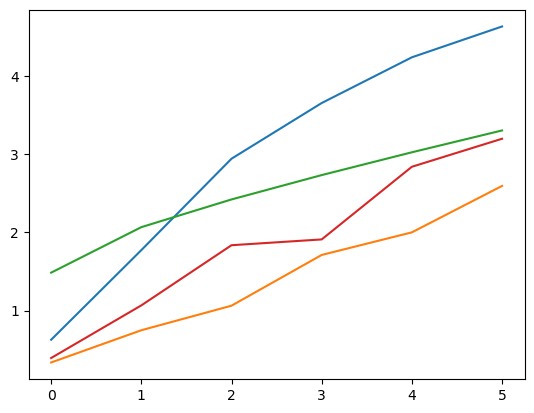

In [16]:
a = torch.load("/home/zhoujk/norm_gauss_mu_vs_35.pt")
a = a.detach().numpy() 
plt.plot(a[:6,0])
plt.plot(a[:6,1])
plt.plot(a[:6,2])
plt.plot(a[:6,3])
a